In [18]:
import requests
from urllib.parse import urlencode
import pandas as pd
import numpy as np
from scipy.stats import norm
import math

from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

## Задание 1. A/B–тестирование

### 1.1 Постановка задачи

Одной из основных задач аналитика является корректное проведение экспериментов с помощью A/B–тестирования. В ходе тестирования одной гипотезы целевой группе посетителей сайта была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. 

Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех посетителей сайта.

### 1.2 Входные данные

В качестве входных данных есть 4 csv-файла:

* groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

* groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

* active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

* checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### 1.3 Решение

Для начала определимся с метриками, которые будем использовать в исследовании.

Что может являться целью введения новой механики оплаты услуг на сайте? 

1. Увеличение среднего чека (например, если новый дизайн позволяет добавлять товары в заказ в процессе оформления заказа в корзине);


2. Увеличение количества оплат на сайте (например, когда новая механика - это удобная оплата в пару кликов).

Следовательно, необходимо проверить как повлияла новая механика оплаты услуг на:

1. ARPPU (Average revenue per paying user) - средний доход на платящего пользователя (то есть клиента). Рассчитывается как отношение дохода(выручки) к количеству клиентов;

2. ARPU (Average revenue per user) - cредний доход с привлечённого пользователя (посетителя сайта). Рассчитывается как отношение дохода(выручки) к количеству посетителей сайта.

3. Конверсию (conversion rate, CR) — отношение числа пользователей, которые совершили покупку, к общему числу пользователей, которые заходили на сайт во время проведения эксперимента.


#### Первичное исследование данных

In [19]:
def get_download_url(public_key):
    """
    Функция для формирования ссылки на csv-файл.
    public_key - ссылка на загружаемый csv-файл на Яндекс.Диске.
    """   
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    # Запрос ссылки на скачивание
    response = requests.get(final_url) 
    # 'Парсинг' ссылки на скачивание
    download_url = response.json()['href']
    return download_url

In [20]:
# Загружаем groups.csv в pandas dataframe и выводим первые 5 строк, чтобы убедиться в корректности загрузки 
groups = pd.read_csv(get_download_url('https://disk.yandex.ru/d/58Us0DWOzuWAjg'), sep=';')
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [9]:
# Посмотрим на описательные статистики датафрейма
groups.describe(include='all')  

,id,grp
count,7.448400e+04,74484
unique,NaN,2
top,NaN,B
freq,NaN,59813
mean,2.133752e+06,NaN
std,1.531423e+06,NaN
min,1.489000e+03,NaN
25%,9.174980e+05,NaN
50%,1.667190e+06,NaN
75%,3.322955e+06,NaN


Всего в датафрейме 74 484 записи, в тестовой группе ("В") 59 813, в контрольной ("А")  74 484 - 59 813 = 14 671. 

In [7]:
def show_piechart(groups, title):
    """
    Функция для вывода piechart, иллюстрирующего соотношение количества пользователей в группах А и В.
    groups - датафрейм с колонкой "grp", на основании которой строится piechart.
    title - заголовок piechart.
    """   
    # Количество пользователей в контрольной группе
    count_control = groups[groups['grp'] == 'A'].count()[0]
    # Количество пользователей в экспериментальной(тестовой) группе
    count_test = groups[groups['grp'] == 'B'].count()[0]
    df = pd.DataFrame({'count': [count_control, count_test]},
                      index=['Control', 'Test'])
    plot = df.plot.pie(y='count', figsize=(5, 5), labels=[count_control, count_test])
    plot.set_title(title)
    
    labels = ['Control group {:.2f}%'.format(100 * count_control / (count_control + count_test)),
              'Test group {:.2f}%'.format(100 * count_test / (count_control + count_test))]
    plot.legend(labels, loc="best")
    None

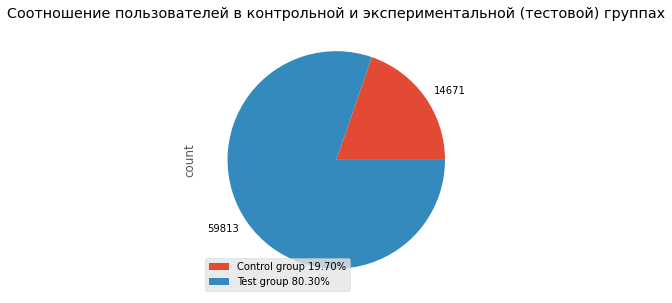

In [5]:
show_piechart(groups, 'Соотношение пользователей в контрольной и экспериментальной (тестовой) группах')

Отметим, что изначально количество пользователей в экспериментальной группе в 4,08 раза превышает количество пользователей в контрольной группе. 

In [23]:
# Загружаем active_studs.csv в pandas dataframe и выводим первые 5 строк, чтобы убедиться в корректности загрузки 
active_studs = pd.read_csv(get_download_url('https://disk.yandex.ru/d/prbgU-rZpiXVYg'), sep=',')
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [24]:
# Загружаем checks.csv в pandas dataframe и выводим первые 5 строк, чтобы убедиться в корректности загрузки 
checks = pd.read_csv(get_download_url('https://disk.yandex.ru/d/84hTmELphW2sqQ'), sep=';')
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


Проверим, есть ли в checks(т.е. среди совершавших оплаты в дни эксперимента) такие, кто не попал в active_studs:

In [29]:
checks[~checks['student_id'].isin(active_studs['student_id'])]['student_id'].nunique()

149

Действительно, выявлено 149 студентов, которые по какой-то причине не попали в файл с active_studs, хотя они совершали оплаты в дни проведения эксперимента и, следовательно, заходили на платформу. 

Добавим их student_id в active_studs:

In [30]:
active_studs_ext = pd.concat([active_studs, checks[~checks['student_id'].isin(active_studs['student_id'])]])
active_studs_ext = active_studs_ext.drop(['rev'], axis=1)

In [31]:
# Оплаты пользователей, которые зашли на сайт в дни проведения экперимента
active_checks = active_studs_ext.merge(checks, how='left', left_on='student_id', right_on='student_id')

In [32]:
# Датафрейм с распределением  по группам пользователей, которые зашли на сайт в дни проведения экперимента
df = active_checks.merge(groups, how='left', left_on='student_id', right_on='id').drop(['id'], axis=1)
df.head()

,student_id,rev,grp
0,581585,NaN,A
1,5723133,NaN,NaN
2,3276743,NaN,B
3,4238589,NaN,A
4,4475369,NaN,B


In [33]:
# Посмотрим, сколько пользователей не принадлежат ни к одной группе (NaN в качестве значения grp); 
# возможно, эти пользователи есть в файле, который прислали через 2 дня после начала эксперимента)
df[df['grp'].isna()]['student_id'].count()

13

In [34]:
df.shape

(8490, 3)

In [35]:
# Заменим NaN в столбце rev на 0.0 - деньги не могут быть NaN
df['rev'] = df['rev'].fillna(0.)
df.head()

,student_id,rev,grp
0,581585,0.0,A
1,5723133,0.0,NaN
2,3276743,0.0,B
3,4238589,0.0,A
4,4475369,0.0,B


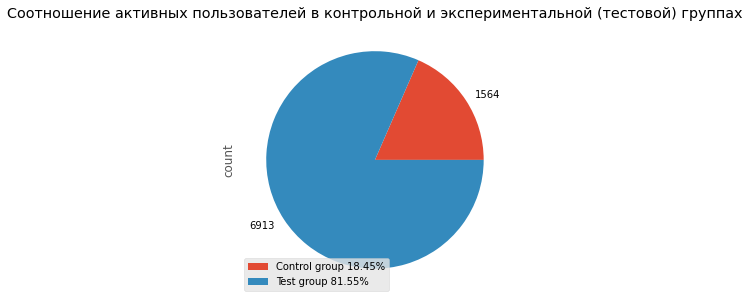

In [36]:
show_piechart(df, 'Соотношение активных пользователей в контрольной и экспериментальной (тестовой) группах')

In [706]:
# Убедимся, что все student_id в датафрейме уникальны:
df['student_id'].duplicated().sum()

0

#### Сравнение ARPPU и ARPU в контрольной и тестовой группах

Необходимо помнить, что не все пользователи из тех, что заходили на платформу в дни проведения эксперимента, совершали покупки.

Для корректного расчета ARPPU оставим только тех пользователей, у кого revenue не равно 0. 

In [37]:
# Формируем контрольную и тестовую выборки для расчета ARPPU  
control = df[(df['grp'] == 'A') & (df['rev'] > 0)]['rev']
test = df[(df['grp'] == 'B') & (df['rev'] > 0)]['rev']

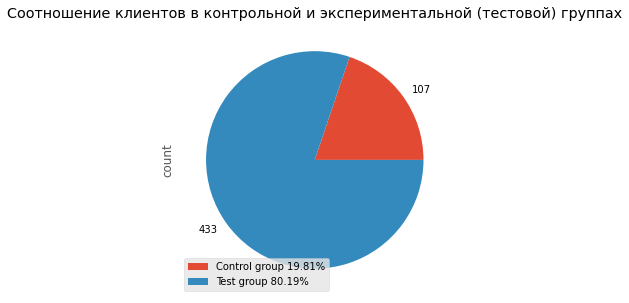

In [469]:
df1 = pd.DataFrame({'grp': 'A', 'rev': control})
df2 = pd.DataFrame({'grp': 'B', 'rev': test})
show_piechart(pd.concat([df1, df2]), 'Соотношение клиентов в контрольной и экспериментальной (тестовой) группах')

In [400]:
print("Количество платежей в контрольной выборке: {}.\nКоличество платежей в тестовой выборке: {}."
      .format(control.size, test.size)) 

Количество платежей в контрольной выборке: 107.
Количество платежей в тестовой выборке: 433.


Построим графики распределения контрольной и тестовой выборок, чтобы определиться с методом для сравнения ARPPU в выборках.

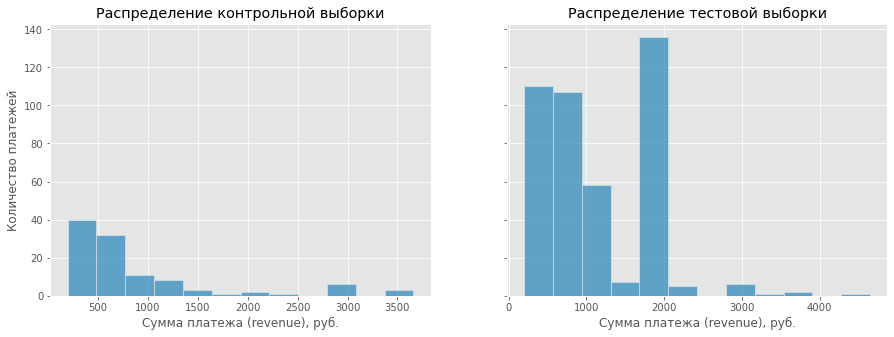

In [383]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)
sns.histplot(control, ax=ax1)
ax1.set_title('Распределение контрольной выборки')
ax1.set(xlabel='Сумма платежа (revenue), руб.', ylabel='Количество платежей')

sns.histplot(test, ax=ax2)
ax2.set_title('Распределение тестовой выборки')
ax2.set(xlabel='Сумма платежа (revenue), руб.', ylabel='Количество платежей')
None

In [63]:
# ARPPU (общая сумма платежей / количество плательщиков)
print("ARPPU в контрольной выборке: {:.2f}.\nARPPU в тестовой выборке: {:.2f}."
      .format(control.mean(), test.mean())) 
print()
# ARPU (общая сумма платежей / количество посетителей сайта)
print("ARPU в контрольной выборке: {:.2f}.\nARPU в тестовой выборке: {:.2f}."
      .format(control.sum() / df[(df['grp'] == 'A')]['grp'].size,
              test.sum() / df[(df['grp'] == 'B')]['grp'].size)) 
print()
print("Медиана суммы платежа в контрольной выборке: {}.\nМедиана суммы платежа в тестовой выборке: {}."
      .format(control.median(), test.median())) 

ARPPU в контрольной выборке: 860.71.
ARPPU в тестовой выборке: 1107.00.

ARPU в контрольной выборке: 58.88.
ARPU в тестовой выборке: 69.34.

Медиана суммы платежа в контрольной выборке: 690.0.
Медиана суммы платежа в тестовой выборке: 880.0.


Видно, что различия между контрольной и тестовой выборками есть, однако необходимо это подтвердить с помощью статистики.

Распределения платежей в обеих группах отличаются от нормального (не симметричные, с выбросами). Кроме того, сохраняется дисбаланс в количестве наблюдений, заданный изначальным дизайном эсперимента. Поэтому применение t-теста не представляется возможным.

Также не подходит и Манн-Уитни, который, как и любой статистический оценщик, не очень приветлив к дисбалансу между группами. Это сказывается в первую очередь на мощности критерия – чем сильнее дисбаланс, тем реже критерий будет обнаруживать реальную разницу.

Кроме того, критерий Манна-Уитни проверяет гипотезу о равенстве распределений, в то время как нам нужно сравнить средние(ARPPU), ARPU и, судя по виду распределений, медианы выборок. Поэтому для проверки есть ли статистически значимые отличия будем использовать бутстрап. 

In [366]:
def get_bootstrap(
    # числовые значения первой выборки
    data_column_1,
    # числовые значения второй выборки
    data_column_2,
    # количество бутстрап-подвыборок
    boot_it=1000, 
    # интересующая нас статистика
    statistic=np.mean, 
    # уровень значимости
    bootstrap_conf_level=0.95 
):
    """
    Функция для проверки гипотез с помощью бутстрапа.
    Возвращаемые значения:
        boot_data - список значений статистики, рассчитанных на бутстрап-подвыборках(длина списка равна boot_it).
        ci - доверительный интервал
        p_value - p_value
    """     
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    # извлекаем подвыборки
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            boot_len, 
            # параметр возвращения
            replace=True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        # - применяем статистику
        boot_data.append(statistic(samples_1 - samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

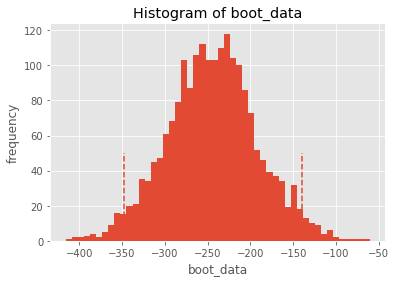

In [386]:
# Строим распределение бутстрап-выборок для ARPPU; в результате хранится разница двух распределений, ДИ и pvalue 
booted_data = get_bootstrap(control, test, boot_it=2000) 

In [387]:
booted_data["p_value"]

3.312191166543306e-06

In [388]:
# Доверительный интервал
booted_data["ci"]

,0
0.025,-348.145621
0.975,-140.262191


0 не попал в доверительный интервал распредения bootstrap, p_value < 0.05, а, значит, на заданном уровне значимости мы **отклоняем нулевую гипотезу** о том, что между ARPPU контрольной и тестовой групп нет статистически значимых отличий.

Теперь сравним ARPU групп.

In [707]:
# Подготовим выборки для расчета ARPU, заполнив все NaN-значения оплат нулями.
control_ARPU = df[df.grp == 'A'].rev.fillna(0)
test_ARPU = df[df.grp == 'B'].rev.fillna(0)

  0%|          | 0/2000 [00:00<?, ?it/s]

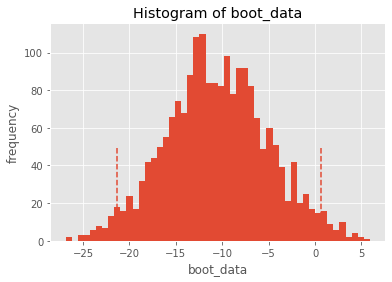

In [708]:
# Строим распределение бутстрап-выборок для ARPU 
booted_data_ARPU = get_bootstrap(control_ARPU, test_ARPU, boot_it=2000)

In [711]:
booted_data_ARPU["p_value"] 

0.0552058083640986

In [712]:
# Доверительный интервал
booted_data_ARPU["ci"]

,0
0.025,-21.342992
0.975,0.618920


0 попал в доверительный интервал распредения bootstrap, p-value > 0.05, а, значит, на заданном уровне значимости мы должны принять нулевую гипотезу о том, что между ARPU контрольной и тестовой групп нет статистически значимых отличий.

Теперь сравним медианы выборок.

In [54]:
data_column_1, data_column_2 = control, test
boot_it = 1000
boot_len = max([len(data_column_1), len(data_column_2)])
boot_data_1, boot_data_2 = [], []
# Извлекаем подвыборки
for i in tqdm(range(boot_it)): 
    samples_1 = data_column_1.sample(boot_len, replace=True).values
    samples_2 = data_column_2.sample(boot_len, replace=True).values
    # По каждой подвыбоке считаем медиану и добавляем в соответствующий список
    boot_data_1.append(np.median(samples_1))
    boot_data_2.append(np.median(samples_2))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [52]:
# Вычисляем разницу
boot_data = np.array(boot_data_1) - np.array(boot_data_2)

In [61]:
# Вычисляем доверительный интервал в получившемся распределении разницы
boot_conf_level = 0.95
left_ci = (1 - boot_conf_level) / 2
right_ci = 1 - (1 - boot_conf_level) / 2
ci = pd.Series(boot_data).quantile([left_ci, right_ci])

print('Доверительный интервал:\n', ci)

Доверительный интервал:
 0.025   -400.0
0.975   -150.0
dtype: float64


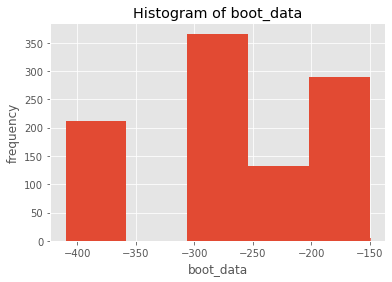

In [62]:
plt.hist(boot_data, bins=5)
plt.style.use('ggplot')
plt.vlines(ci, ymin=0, ymax=5, linestyle='--')
plt.xlabel('boot_data')
plt.ylabel('frequency')
plt.title("Histogram of boot_data")
plt.show()

0 не попал в доверительный интервал распредения разницы, а, значит, на заданном уровне значимости мы **отклоняем нулевую гипотезу** о том, что между медианами контрольной и тестовой групп нет статистически значимых отличий.

Таким образом, применение новой механики оплаты позволяет добиться статистически значимого увеличения ARPPU(по сути, среднего чека на платящего пользователя), при отсутствии статистически значимых отличий в ARPU. 

#### Сравнение СR в контрольной и тестовой группах

Как отмечалось ранее, не все пользователи из тех, что заходили на платформу во время проведения экперимента, совершали покупки. Необходимо удостовериться, что рост ARPPU(среднего чека на платящего пользователя) в тестовой группе не сопровождается снижением конверсии в покупку (CR).  

Для начала рассчитаем значения CR для обеих групп.

In [599]:
a_CR = (control.size / control_ARPU.size) * 100
b_CR = (test.size / test_ARPU.size) * 100
print("CR в контрольной выборке: {:.3f}.\nCR в тестовой выборке: {:.3f}. \nРазность CR: {:.3f}."
      .format(a_CR, b_CR, a_CR - b_CR))

CR в контрольной выборке: 6.841.
CR в тестовой выборке: 6.278. 
Разность CR: 0.563.


CR контрольной выборки немного выше CR тестовой выборки, однако следует проверить, является ли эта разница статистически значимой.

In [488]:
# Преобразуем данные в numpy-матрицу 2x2 для вычисления критерия хи-квадрат Пирсона.
T = np.array([[control.size, (control_ARPU.size - control.size)], [test.size, (test_ARPU.size - test.size)]])
T

array([[ 107, 1457],
       [ 433, 6480]])

In [493]:
import scipy
print('p-value = {:.4f}'.format(scipy.stats.chi2_contingency(T, correction=False)[1]))

p-value = 0.3981


Расчетное значение  p-value равно 0.3981, а поскольку принятый в данном исследовании уровень значимости равен 0,05, то при p-value > 0.05 мы принимаем нулевую гипотезу о равенстве значений CR. 

То есть применение новой механики оплаты не повлияло на конверсию сайта.

**Вывод:** новая механика оплаты позволяет увеличить средний доход на платящего пользователя (ARPPU) при сохранении того же уровня конверсии в покупку (CR), в связи с чем рекомендуется ее распространение на всех пользователей сайта. 

### 2. Расширение функционала (дополнительное задание)

1. Реализовать функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

2. Реализовать функцию, которая будет строить графики по получаемым метрикам.

In [64]:
def get_metrics(
    # ссылка на допольнительный csv-файл, расположенный на Яндекс.Диске
    groups_add_url,
    # ранее загруженный датафрейм с id всех пользователей, участвующих в эксперименте
    groups=groups, 
    # ранее загруженный датафрейм с id активных пользователей
    active_studs=active_studs,
    # ранее загруженный датафрейм с оплатами пользователей
    checks=checks 
):
    """
    Функция автоматически подгружает информацию из дополнительного файла groups_add.csv (заголовки могут отличаться), и,
    на основании дополнительных параметров, пересчитывает метрики.
    Возвращаемые значения: словарь с пересчитанными метриками (ARPPU, ARPU, медиана, CR)        
    """     
    # Загружаем groups_add.csv в pandas dataframe
    groups_add = pd.read_csv(get_download_url(groups_add_url), sep=',')
    
    # Делаем заголовки столбцов в новом и старом файлах одинаковыми
    c_groups = groups.columns
    c_groups_add = groups_add.columns
    groups_add = groups_add.rename(columns={c_groups_add[0]: c_groups[0], c_groups_add[1]: c_groups[1]})
    
    # Объединяем новый и старый файлы 
    all = pd.concat([groups_add, groups])

    # Проверим, есть ли дублирующтеся значения id
    if all['id'].duplicated().sum():
        #  Если такие значения есть, оставляем только первое значение
        all = all.drop_duplicates(subset=['id'], keep="first")    
    
    # Объединяем all с файлом, в котором указаны активные студенты
    all = all.merge(active_studs, how='left', left_on='id', right_on='student_id')
    # Переименовываем колонку 'student_id' в 'active'
    all = all.rename(columns={'student_id': 'active'})
    # Присваиваем NaN в active значения 0, не NaN - 1, чтобы обозначить активных студентов
    all['active'] = all['active'].apply(lambda x: 0 if math.isnan(x) else 1) 
    
    # Объединяем all с файлом с оплатами, заполняем NaN в колонке rev("revenue", "доход") нулями
    all = all.merge(checks, how='left', left_on='id', right_on='student_id').drop(['student_id'], axis=1)
    all['rev'] = all['rev'].fillna(0)
    
    # Формируем контрольную и тестовую выборки для расчетов
    control = all[(all['grp'] == 'A') & (all['rev'] > 0)]['rev']
    test = all[(all['grp'] == 'B') & (all['rev'] > 0)]['rev']
    
    # Пересчитываем метрики
    ARPPU_control = control.mean()
    ARPPU_test = test.mean()

    ARPU_control = control.sum() / all[(all['grp'] == 'A') & (all['active'] == 1)]['grp'].size
    ARPU_test = test.sum() / all[(all['grp'] == 'B') & (all['active'] == 1)]['grp'].size

    Median_control = control.median()
    Median_test = test.median()

    CR_control = (control.size / all[(all['grp'] == 'A') & (all['active'] == 1)].rev.fillna(0).size) * 100
    CR_test = (test.size / all[(all['grp'] == 'B') & (all['active'] == 1)].rev.fillna(0).size) * 100
    
    return {'ARPPU_control': ARPPU_control,
            'ARPPU_test': ARPPU_test,
            'ARPU_control': ARPU_control,
            'ARPU_test': ARPU_test,
            'Median_control': Median_control,
            'Median_test': Median_test,
            'CR_control': CR_control,
            'CR_test': CR_test}

In [65]:
metrics = get_metrics('https://disk.yandex.ru/d/3aARY-P9pfaksg')

In [66]:
def show_metrics(metrics=metrics):
    """
    Функция строит графики по получаемым метрикам.
    """
    # Выбираем "денежные" метрики (ARPPU, ARPU, медианы)
    revenue_metics = list(metrics.items())[:-2]
    # Формируем из них датафрейм
    t1 = pd.DataFrame.from_dict(revenue_metics).rename(columns={0: 'Metrics', 1: 'Revenue, rub.'}).set_index('Metrics')
    # Строим график
    ax1 = t1.plot.bar()
    ax1.set_title('ARPPU, ARPU, медианы в контрольной и тестовой группах')  

    # Выбираем CR
    CR_metics = list(metrics.items())[-2:]
    # Формируем из них датафрейм
    t2 = pd.DataFrame.from_dict(CR_metics).rename(columns={0: 'CR', 1: 'CR, %'}).set_index('CR')
    # Строим график
    ax2 = t2.plot.bar()
    ax2.set_title('CR в контрольной и тестовой группах')
    None

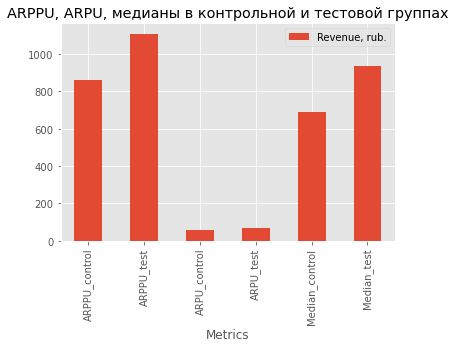

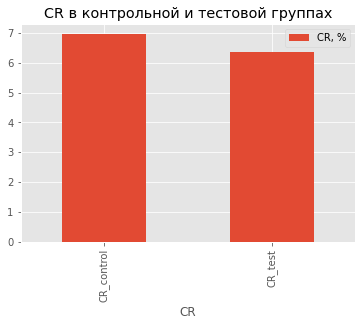

In [28]:
show_metrics(metrics)